In [ ]:
# Cell 1: Install Libraries
print("Installing required libraries...")
!pip install -q kaggle opencv-python-headless scikit-learn matplotlib seaborn pandas
print("Libraries installed.")

Installing required libraries...
Libraries installed.


In [ ]:
# Cell 1a: Install LightGBM
print("Installing LightGBM...")
!pip install -q lightgbm
print("LightGBM installed.")

Installing LightGBM...
LightGBM installed.


In [ ]:
# Cell 2: Setup Kaggle API
import os
from google.colab import files

print("\nPlease upload your 'kaggle.json' file.")
try:
    # Clear any previous kaggle.json if it exists to avoid conflicts
    if os.path.exists('kaggle.json'):
        os.remove('kaggle.json')

    uploaded = files.upload() # Prompt user to upload kaggle.json

    if 'kaggle.json' not in uploaded:
        raise FileNotFoundError("kaggle.json was not uploaded.")

    # Make directory for Kaggle API credentials if it doesn't exist
    kaggle_dir = '/root/.kaggle'
    os.makedirs(kaggle_dir, exist_ok=True)

    # Move the kaggle.json to the correct folder
    !cp kaggle.json {kaggle_dir}/

    # Set permissions for the Kaggle API key
    !chmod 600 {kaggle_dir}/kaggle.json
    print("Kaggle API setup complete.")

except Exception as e:
    print(f"\nError during Kaggle setup: {e}")
    print("Please ensure you uploaded the 'kaggle.json' file correctly.")



Please upload your 'kaggle.json' file.


Saving kaggle.json to kaggle.json
Kaggle API setup complete.


In [ ]:
# Cell 3: Download and Extract FER2013 Dataset
import zipfile
import os

print("\nDownloading FER2013 dataset from Kaggle...")
# Use -q for quieter download, remove if you want to see progress
!kaggle datasets download -d msambare/fer2013 -q --force

zip_path = "fer2013.zip"
extract_dir = "/content/fer2013_data"

# Remove previous extraction directory if it exists to ensure clean state
if os.path.exists(extract_dir):
    print(f"Removing previous extraction directory: {extract_dir}")
    !rm -rf {extract_dir}

if os.path.exists(zip_path):
    print(f"Extracting {zip_path} to {extract_dir}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Extraction complete.")
        # Optional: List extracted contents to verify
        print("Top-level extracted contents:", os.listdir(extract_dir))
        # Clean up the zip file
        os.remove(zip_path)
        print(f"{zip_path} removed.")
    except zipfile.BadZipFile:
        print(f"Error: Failed to unzip the file. It might be corrupted or incomplete.")
    except Exception as e:
         print(f"An error occurred during extraction: {e}")
else:
    print(f"Error: Dataset zip file '{zip_path}' not found after download attempt.")
    print("Please check Kaggle download status and permissions.")



Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 58% 35.0M/60.3M [00:00<00:00, 338MB/s]
100% 60.3M/60.3M [00:00<00:00, 300MB/s]
Removing previous extraction directory: /content/fer2013_data
Extracting fer2013.zip to /content/fer2013_data...
Extraction complete.
Top-level extracted contents: ['test', 'train']
fer2013.zip removed.


In [ ]:
# Cell 4: Define Image Preprocessing Function
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


NEW_IMG_SIZE = 96


def preprocess_images(image_dir, target_size=NEW_IMG_SIZE):
    """Loads, grayscales, resizes (to target_size), and normalizes images."""
    images = []
    labels = []
    emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
    emotion_map_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    print(f"Preprocessing images from: {image_dir} to size {target_size}x{target_size}")
    if not os.path.isdir(image_dir):
        print(f"Error: Directory not found - {image_dir}")
        return None, None, None

    # Loop through defined emotions to ensure correct label assignment
    for emotion, label in emotion_labels.items():
        emotion_dir = os.path.join(image_dir, emotion)
        if not os.path.isdir(emotion_dir):
            continue

        image_files = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]

        for image_name in image_files:
            image_path = os.path.join(emotion_dir, image_name)
            try:
                img = cv2.imread(image_path)
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # --- Use the target_size in resize ---
                img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"    Warning: Error processing image {image_path}: {e}")

    if not images:
        print(f"Error: No images successfully processed in {image_dir}.")
        return None, None, None

    images = np.array(images) / 255.0 # Normalize here
    labels = np.array(labels)

    print(f"Finished preprocessing {image_dir}. Loaded {len(images)} images.")
    return images, labels, emotion_map_list

print(f"Preprocessing function defined for target size {NEW_IMG_SIZE}x{NEW_IMG_SIZE}.")

Preprocessing function defined for target size 96x96.


In [ ]:
# Cell 5: Load and Preprocess Train/Test Data

# Define paths using the extraction directory from Cell 3
base_extract_dir = "/content/fer2013_data"
train_dir = os.path.join(base_extract_dir, "train")
test_dir = os.path.join(base_extract_dir, "test")

print("\nLoading and preprocessing training data...")
X_train, y_train, emotion_map_list = preprocess_images(train_dir)

print("\nLoading and preprocessing testing data...")
X_test, y_test, _ = preprocess_images(test_dir)

if X_train is None or X_test is None or y_train is None or y_test is None or emotion_map_list is None:
    print("\nFATAL ERROR: Data loading failed. Cannot proceed.")
    print("Please check the extraction directory structure and file integrity in Cell 3.")
else:
    print("\nData loaded successfully.")
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")
    print(f"Emotion labels: {emotion_map_list}")




Loading and preprocessing training data...
Preprocessing images from: /content/fer2013_data/train to size 96x96
Finished preprocessing /content/fer2013_data/train. Loaded 28709 images.

Loading and preprocessing testing data...
Preprocessing images from: /content/fer2013_data/test to size 96x96
Finished preprocessing /content/fer2013_data/test. Loaded 7178 images.

Data loaded successfully.
Training data shape: X=(28709, 96, 96), y=(28709,)
Test data shape: X=(7178, 96, 96), y=(7178,)
Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# Cell 6: Prepare Data for PCA (Flatten and Scale)
from sklearn.preprocessing import StandardScaler

print("\n--- Preparing Data for PCA ---")

if 'X_train' in locals() and 'X_test' in locals(): # Check if data exists
    # --- 6.1 Flatten the images ---
    n_samples_train, img_height, img_width = X_train.shape
    n_samples_test = X_test.shape[0]
    n_features = img_height * img_width

    X_train_flat = X_train.reshape(n_samples_train, n_features)
    X_test_flat = X_test.reshape(n_samples_test, n_features)
    print(f"Flattened X_train shape: {X_train_flat.shape}")
    print(f"Flattened X_test shape: {X_test_flat.shape}")

    # --- 6.2 Scale the data ---
    scaler = StandardScaler()
    print("Scaling training data (fitting scaler)...")
    X_train_scaled = scaler.fit_transform(X_train_flat)
    print("Scaling test data (using fitted scaler)...")
    X_test_scaled = scaler.transform(X_test_flat)
    print("Data flattened and scaled.")
else:
    print("Skipping: Data variables (X_train, X_test) not found from previous cell.")


--- Preparing Data for PCA ---
Flattened X_train shape: (28709, 9216)
Flattened X_test shape: (7178, 9216)
Scaling training data (fitting scaler)...
Scaling test data (using fitted scaler)...
Data flattened and scaled.


In [ ]:
# Cell 6a: Save the Scaler
import joblib
import os
from google.colab import drive

print("\n--- Saving Scaler ---")
save_obj_locally = True # Option to also save locally
save_obj_drive = True # Option to save to drive

# --- Mount Drive if saving there ---
drive_mounted = False
if save_obj_drive:
    if not os.path.exists('/content/drive/MyDrive'):
        try:
            print("Mounting Google Drive...")
            drive.mount('/content/drive', force_remount=True)
            drive_mounted = True
        except Exception as e:
            print(f"Error mounting Google Drive: {e}. Will only save locally.")
            save_obj_drive = False # Disable drive saving if mount fails
    else:
        print("Google Drive already mounted.")
        drive_mounted = True
# ---------------------------------

# Check if scaler exists
if 'scaler' in locals():
    # Local Path
    local_save_dir = "/content/saved_models"
    os.makedirs(local_save_dir, exist_ok=True)
    local_scaler_filename = os.path.join(local_save_dir, "scaler_96x96.joblib")

    # Drive Path
    drive_scaler_filename = None
    if save_obj_drive and drive_mounted:
        drive_save_dir = "/content/drive/MyDrive/Colab_Models"
        os.makedirs(drive_save_dir, exist_ok=True)
        drive_scaler_filename = os.path.join(drive_save_dir, "scaler_96x96.joblib")

    # Save Locally
    if save_obj_locally:
        try:
            print(f"Saving scaler locally to: {local_scaler_filename}")
            joblib.dump(scaler, local_scaler_filename)
            print("Scaler saved locally.")
        except Exception as e: print(f"Error saving scaler locally: {e}")

    # Save to Drive
    if save_obj_drive and drive_scaler_filename:
         try:
            print(f"Saving scaler to Google Drive: {drive_scaler_filename}")
            joblib.dump(scaler, drive_scaler_filename)
            print("Scaler saved to Google Drive.")
         except Exception as e: print(f"Error saving scaler to Drive: {e}")

else:
    print("Skipping scaler saving: 'scaler' object not found.")


--- Saving Scaler ---
Mounting Google Drive...
Error mounting Google Drive: Error: credential propagation was unsuccessful. Will only save locally.
Saving scaler locally to: /content/saved_models/scaler_96x96.joblib
Scaler saved locally.



--- Applying PCA for Visualization (2 Components) ---
Fitting PCA and transforming training data...
Shape after PCA: (28709, 2)
Explained variance by 2 components: 0.3840
Generating scatter plot...


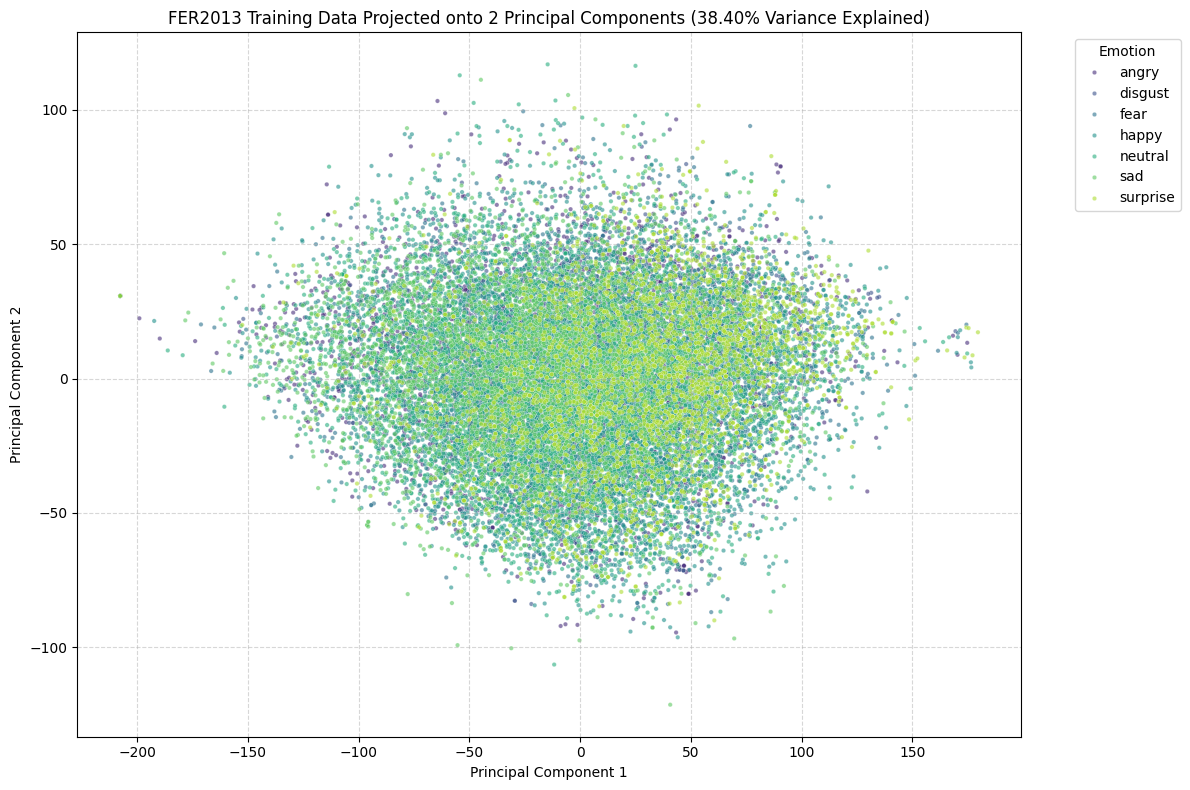

Visualization complete.


In [ ]:
# Cell 7: Apply PCA for Visualization
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Applying PCA for Visualization (2 Components) ---")

if 'X_train_scaled' in locals() and 'y_train' in locals():
    pca_vis = PCA(n_components=2, random_state=42)
    print("Fitting PCA and transforming training data...")
    X_train_pca_vis = pca_vis.fit_transform(X_train_scaled)
    explained_variance = np.sum(pca_vis.explained_variance_ratio_)
    print(f"Shape after PCA: {X_train_pca_vis.shape}")
    print(f"Explained variance by 2 components: {explained_variance:.4f}")

    print("Generating scatter plot...")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x=X_train_pca_vis[:, 0],
        y=X_train_pca_vis[:, 1],
        hue=[emotion_map_list[label] for label in y_train],
        palette='viridis', alpha=0.6, s=10
    )
    plt.title(f'FER2013 Training Data Projected onto 2 Principal Components ({explained_variance:.2%} Variance Explained)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    print("Visualization complete.")
else:
    print("Skipping: Scaled training data or labels not found.")

In [ ]:
# Cell 8: Train Baseline Model (LightGBM - Before PCA)
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import time

print("\n--- Training Baseline Model (LightGBM - Before PCA) ---")

# Initialize placeholder variables in case of skip
accuracy_baseline = None
train_time_baseline = None
predict_time_baseline = None

if 'X_train_scaled' in locals() and 'X_test_scaled' in locals() and 'y_train' in locals() and 'y_test' in locals():
    print("Note: Using LightGBM for comparison.")

    baseline_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

    print("Training baseline LightGBM model...")
    start_time = time.time()
    baseline_model.fit(X_train_scaled, y_train)
    train_time_baseline = time.time() - start_time
    time.sleep(0.1)
    print(f"Baseline LightGBM Training Time: {train_time_baseline:.2f} seconds")

    print("Evaluating baseline LightGBM model...")
    start_time = time.time()
    try:
        y_pred_baseline = baseline_model.predict(X_test_scaled)
        predict_time_baseline = time.time() - start_time
        accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
        print(f"Baseline LightGBM Prediction Time: {predict_time_baseline:.2f} seconds")
        print(f"Baseline LightGBM Model Accuracy: {accuracy_baseline:.4f}")

    except Exception as e:
        print(f"Could not evaluate baseline LightGBM: {e}")
        accuracy_baseline = None

else:
    print("Skipping: Required scaled data or labels not found.")

In [ ]:
# Cell 8a: Save Trained Baseline LightGBM Locally and to Google Drive
import joblib
import os
import time
from google.colab import drive

print("\n--- Saving Baseline LightGBM Model (Locally & Google Drive) ---")

# --- Define Local Path ---
local_save_dir = "/content/saved_models"
os.makedirs(local_save_dir, exist_ok=True)
local_model_filename = os.path.join(local_save_dir, "lgbm_baseline_96x96_model.joblib")
# ------------------------

# --- Mount Google Drive ---
try:
    print("Mounting Google Drive...")
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
    drive_mounted = True
    # --- Define Drive Path ---
    drive_save_dir = "/content/drive/MyDrive/Colab_Models"
    os.makedirs(drive_save_dir, exist_ok=True)
    drive_model_filename = os.path.join(drive_save_dir, "lgbm_baseline_96x96_model.joblib")
    # ------------------------
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Model will only be saved locally (temporarily).")
    drive_mounted = False
    drive_model_filename = None
# -------------------------

# Check if the baseline_model exists and training completed
if 'baseline_model' in locals() and 'accuracy_baseline' in locals() and accuracy_baseline is not None:
    model_saved_locally = False
    model_saved_on_drive = False

    # --- Attempt 1: Save Locally ---
    try:
        print(f"\nAttempting to save model locally to: {local_model_filename}")
        joblib.dump(baseline_model, local_model_filename)
        print("Model saved successfully locally.")
        model_saved_locally = True
        # Verify local file
        if os.path.exists(local_model_filename):
            print(f"Verified: Local file '{local_model_filename}' exists.")
        else:
            print("Warning: Local model file not found after saving attempt.")
    except Exception as e:
        print(f"Error saving model locally: {e}")
    # -----------------------------

    # --- Attempt 2: Save to Google Drive (if mounted) ---
    if drive_mounted and drive_model_filename:
        try:
            print(f"\nAttempting to save model to Google Drive: {drive_model_filename}")
            joblib.dump(baseline_model, drive_model_filename)
            print("Model saved successfully to Google Drive.")
            model_saved_on_drive = True
            if os.path.exists(drive_model_filename):
                print(f"Verified: Google Drive file '{drive_model_filename}' exists.")
            else:
                print("Warning: Google Drive model file not found after saving attempt.")
        except Exception as e:
            print(f"Error saving model to Google Drive: {e}")
    elif not drive_mounted:
        print("\nSkipping save to Google Drive (Drive not mounted).")
    # ----------------------------------------------------

    if model_saved_locally or model_saved_on_drive:
         print("\nModel saving process complete.")
    else:
         print("\nModel saving failed in both locations.")

else:
    print("\nSkipping model saving: 'baseline_model' not found or baseline accuracy is missing.")

In [ ]:
# Cell 9: Apply PCA for Dimensionality Reduction (Using Randomized SVD)
import time
from sklearn.decomposition import PCA

print("\n--- Applying PCA for Dimensionality Reduction ---")

n_components_selected = None
X_train_pca = None
X_test_pca = None
pca_model = None

if 'X_train_scaled' in locals() and 'X_test_scaled' in locals():
    n_comp_target = 0.95
    print(f"Initializing PCA to retain {n_comp_target:.0%} of variance...")

    n_components_guess = 1000
    print(f"Using randomized SVD (initial guess for components: {n_components_guess})")
    pca_model = PCA(n_components=n_components_guess, random_state=42, svd_solver='randomized')
    # -----------------------------------

    print("Fitting PCA on training data...")
    start_time_pca_fit = time.time()
    pca_model.fit(X_train_scaled)
    pca_fit_time = time.time() - start_time_pca_fit

    # --- Find how many components actually needed for 95% variance ---
    cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)
    n_components_needed = np.argmax(cumulative_variance >= n_comp_target) + 1
    actual_variance_explained = cumulative_variance[n_components_needed-1]
    n_components_selected = n_components_needed # Update selected component count
    print(f"Components actually needed for >= {n_comp_target:.0%} variance: {n_components_selected}")
    print(f"Actual variance explained by {n_components_selected} components: {actual_variance_explained:.4f}")
    # -----------------------------------------------------------------

    print(f"PCA Fit Time: {pca_fit_time:.2f}s") # Time for fitting with randomized SVD
    print("Transforming training data...")
    if n_components_guess == n_components_selected: # If guess was exact or refitted
         X_train_pca = pca_model.transform(X_train_scaled)
    else:
         components = pca_model.components_[:n_components_selected]
         # Project the data onto these components
         X_train_pca = (X_train_scaled - pca_model.mean_) @ components.T

    print(f"Shape of training data after PCA: {X_train_pca.shape}")


    print("Transforming test data...")
    if n_components_guess == n_components_selected:
        X_test_pca = pca_model.transform(X_test_scaled)
    else: # Transform test data consistently
         components = pca_model.components_[:n_components_selected]
         X_test_pca = (X_test_scaled - pca_model.mean_) @ components.T

    print(f"Shape of test data after PCA: {X_test_pca.shape}")
else:
    print("Skipping: Scaled data not found.")


--- Applying PCA for Dimensionality Reduction ---
Initializing PCA to retain 95% of variance...
Using randomized SVD (initial guess for components: 1000)
Fitting PCA on training data...
Components actually needed for >= 95% variance: 273
Actual variance explained by 273 components: 0.9501
PCA Fit Time: 222.60s
Transforming training data...
Shape of training data after PCA: (28709, 273)
Transforming test data...
Shape of test data after PCA: (7178, 273)


In [ ]:
# Cell 9a: Save the PCA Transformer Model
import joblib
import os
from google.colab import drive

print("\n--- Saving PCA Transformer Model ---")
save_obj_locally = True # Option to also save locally
save_obj_drive = True # Option to save to drive

# --- Mount Drive if saving there ---
# Should be mounted already from previous cell, but check again
drive_mounted = False
if save_obj_drive:
    if not os.path.exists('/content/drive/MyDrive'):
        try:
            print("Mounting Google Drive...")
            drive.mount('/content/drive', force_remount=True)
            drive_mounted = True
        except Exception as e:
            print(f"Error mounting Google Drive: {e}. Will only save locally.")
            save_obj_drive = False
    else:
        # print("Google Drive already mounted.") # Less verbose
        drive_mounted = True
# ---------------------------------

# Check if pca_model (transformer) exists
if 'pca_model' in locals() and pca_model is not None:
     # Local Path
    local_save_dir = "/content/saved_models"
    os.makedirs(local_save_dir, exist_ok=True)
    local_pca_transformer_filename = os.path.join(local_save_dir, "pca_transformer_96x96_c273.joblib") # Include components info

    # Drive Path
    drive_pca_transformer_filename = None
    if save_obj_drive and drive_mounted:
        drive_save_dir = "/content/drive/MyDrive/Colab_Models"
        os.makedirs(drive_save_dir, exist_ok=True)
        drive_pca_transformer_filename = os.path.join(drive_save_dir, "pca_transformer_96x96_c273.joblib")

    # Save Locally
    if save_obj_locally:
        try:
            print(f"Saving PCA transformer locally to: {local_pca_transformer_filename}")
            joblib.dump(pca_model, local_pca_transformer_filename)
            print("PCA transformer saved locally.")
        except Exception as e: print(f"Error saving PCA transformer locally: {e}")

    # Save to Drive
    if save_obj_drive and drive_pca_transformer_filename:
         try:
            print(f"Saving PCA transformer to Google Drive: {drive_pca_transformer_filename}")
            joblib.dump(pca_model, drive_pca_transformer_filename)
            print("PCA transformer saved to Google Drive.")
         except Exception as e: print(f"Error saving PCA transformer to Drive: {e}")
else:
    print("Skipping PCA transformer saving: 'pca_model' object not found or is None.")


--- Saving PCA Transformer Model ---
Mounting Google Drive...
Error mounting Google Drive: Error: credential propagation was unsuccessful. Will only save locally.
Saving PCA transformer locally to: /content/saved_models/pca_transformer_96x96_c273.joblib
PCA transformer saved locally.


In [ ]:
# Cell 10: Train Model After PCA (LightGBM)
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import time

print("\n--- Training Model After PCA (LightGBM) ---")

# Initialize placeholder variables
accuracy_pca = None
train_time_pca = None
predict_time_pca = None

if 'X_train_pca' in locals() and 'X_test_pca' in locals() and 'y_train' in locals() and 'y_test' in locals():
    # --- Use LGBMClassifier ---
    pca_model_lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

    print("Training LightGBM model on PCA data...")
    start_time = time.time()
    pca_model_lgbm.fit(X_train_pca, y_train)
    train_time_pca = time.time() - start_time
    time.sleep(0.1)
    print(f"PCA LightGBM Model Training Time: {train_time_pca:.2f} seconds")

    print("Evaluating LightGBM model on PCA test data...")
    start_time = time.time()
    try:
        y_pred_pca = pca_model_lgbm.predict(X_test_pca)
        predict_time_pca = time.time() - start_time
        accuracy_pca = accuracy_score(y_test, y_pred_pca)
        print(f"PCA LightGBM Model Prediction Time: {predict_time_pca:.2f} seconds")
        print(f"PCA LightGBM Model Accuracy: {accuracy_pca:.4f}") # <-- Expect higher accuracy


    except Exception as e:
        print(f"Could not evaluate PCA LightGBM: {e}")
        accuracy_pca = None
else:
    print("Skipping: PCA-transformed data or labels not found.")

In [ ]:
# Cell 10a: Save Trained PCA LightGBM Model (Locally & Google Drive)
import joblib
import os
import time
from google.colab import drive

print("\n--- Saving PCA LightGBM Model (Locally & Google Drive) ---")

# --- Define Local Path ---
local_save_dir = "/content/saved_models"
os.makedirs(local_save_dir, exist_ok=True)
local_pca_model_filename = os.path.join(local_save_dir, "lgbm_pca_96x96_model.joblib") # PCA model filename
# ------------------------

# --- Mount Google Drive (Check if already mounted, remount if needed) ---
drive_mounted = False
drive_pca_model_filename = None
if not os.path.exists('/content/drive/MyDrive'):
     try:
         print("Mounting Google Drive...")
         drive.mount('/content/drive', force_remount=True)
         print("Google Drive mounted successfully.")
         drive_mounted = True
     except Exception as e:
         print(f"Error mounting Google Drive: {e}")
         print("PCA model will only be saved locally (temporarily).")
else:
    print("Google Drive already mounted.")
    drive_mounted = True

if drive_mounted:
    # --- Define Drive Path ---
    drive_save_dir = "/content/drive/MyDrive/Colab_Models"
    os.makedirs(drive_save_dir, exist_ok=True)
    drive_pca_model_filename = os.path.join(drive_save_dir, "lgbm_pca_96x96_model.joblib")


# Check if the pca_model_lgbm exists and training completed
if 'pca_model_lgbm' in locals() and 'accuracy_pca' in locals() and accuracy_pca is not None:
    model_saved_locally = False
    model_saved_on_drive = False

    # --- Attempt 1: Save Locally ---
    try:
        print(f"\nAttempting to save PCA model locally to: {local_pca_model_filename}")
        joblib.dump(pca_model_lgbm, local_pca_model_filename)
        print("PCA model saved successfully locally.")
        model_saved_locally = True
        # Verify local file
        if os.path.exists(local_pca_model_filename):
            print(f"Verified: Local file '{local_pca_model_filename}' exists.")
        else:
            print("Warning: Local PCA model file not found after saving attempt.")
    except Exception as e:
        print(f"Error saving PCA model locally: {e}")

    # --- Attempt 2: Save to Google Drive (if mounted) ---
    if drive_mounted and drive_pca_model_filename:
        try:
            print(f"\nAttempting to save PCA model to Google Drive: {drive_pca_model_filename}")
            joblib.dump(pca_model_lgbm, drive_pca_model_filename)
            print("PCA model saved successfully to Google Drive.")
            model_saved_on_drive = True
            # Verify Drive file
            if os.path.exists(drive_pca_model_filename):
                print(f"Verified: Google Drive file '{drive_pca_model_filename}' exists.")
            else:
                print("Warning: Google Drive PCA model file not found after saving attempt.")
        except Exception as e:
            print(f"Error saving PCA model to Google Drive: {e}")
    elif not drive_mounted:
        print("\nSkipping save to Google Drive (Drive not mounted).")

    if model_saved_locally or model_saved_on_drive:
         print("\nPCA Model saving process complete.")
    else:
         print("\nPCA Model saving failed in both locations.")

else:
    print("\nSkipping PCA model saving: 'pca_model_lgbm' not found or PCA accuracy is missing.")

In [ ]:
# Cell 10b: Load Saved Baseline LGBM Model Locally & Re-Evaluate
import joblib
import os
import time
from sklearn.metrics import accuracy_score # Need this

print("\n--- Loading Saved Baseline LGBM Model Locally & Re-Evaluating ---")

# --- Define LOCAL path ---
local_save_dir = "/content/saved_models"
model_filename = os.path.join(local_save_dir, "lgbm_baseline_96x96_model.joblib")
# ------------------------

# --- Initialize variables ---
baseline_model = None
accuracy_baseline = None
predict_time_baseline = None

# --- Check if necessary data exists ---
required_data_vars = ['X_test_scaled', 'y_test', 'emotion_map_list']
if not all(var in locals() or var in globals() for var in required_data_vars):
    print("Error: Required data (X_test_scaled, y_test, emotion_map_list) not found.")
    print("Please ensure Cells 1-6 have been run successfully in this session.")
else:
    # --- Load the model from local path ---
    if os.path.exists(model_filename):
        try:
            print(f"Loading saved baseline LGBM model from local path: {model_filename}")
            baseline_model = joblib.load(model_filename)
            print("Baseline LGBM model loaded successfully.")

            # --- Re-run Prediction/Evaluation ---
            print("Re-evaluating loaded baseline LGBM model...")
            start_time = time.time()
            y_pred_baseline = baseline_model.predict(X_test_scaled)
            predict_time_baseline = time.time() - start_time
            accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
            print(f"Recalculated Baseline LGBM Prediction Time: {predict_time_baseline:.2f} seconds")
            print(f"Recalculated Baseline LGBM Model Accuracy: {accuracy_baseline:.4f}")


        except Exception as e:
            print(f"Error loading or predicting with the saved baseline model: {e}")
            baseline_model = None
            accuracy_baseline = None
            predict_time_baseline = None
    else:
        print(f"Error: Saved baseline model file not found at local path {model_filename}.")
        print("Please ensure the model was saved correctly in this session or the path is correct.")
        # Ensure vars are None if file not found
        baseline_model = None
        accuracy_baseline = None
        predict_time_baseline = None

if baseline_model is None or accuracy_baseline is None or predict_time_baseline is None:
    print("\nWarning: Failed to load or re-evaluate baseline model. Comparison in Cell 11 might be incomplete.")
else:
    print("\nBaseline model loaded and re-evaluated successfully.")

In [ ]:
# Cell 11: Compare Performance (LightGBM), Show Random Sample, and Allow User Upload
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files
import joblib
import os
import time

print("\n--- Performance Comparison (LightGBM) ---")

# --- Explicitly retrieve or set None for required comparison variables ---
accuracy_baseline = locals().get('accuracy_baseline', None)
accuracy_pca = locals().get('accuracy_pca', None)
train_time_baseline = locals().get('train_time_baseline', None)
train_time_pca = locals().get('train_time_pca', None)
predict_time_baseline = locals().get('predict_time_baseline', None)
predict_time_pca = locals().get('predict_time_pca', None)
n_components_selected = locals().get('n_components_selected', None)
X_train_scaled_shape_1 = locals().get('X_train_scaled', np.empty((0,0))).shape[1] if 'X_train_scaled' in locals() else None
# ---

# Check if results from both models are available for comparison
comparison_ready = all(v is not None for v in [accuracy_baseline, accuracy_pca, n_components_selected, X_train_scaled_shape_1])

if comparison_ready:
    print(f"Original Features: {X_train_scaled_shape_1}")
    print(f"PCA Features:      {n_components_selected}")

    print(f"\nAccuracy:")
    print(f"  Baseline LightGBM (Original Data): {accuracy_baseline:.4f}")
    print(f"  PCA LightGBM (PCA Data):         {accuracy_pca:.4f}")
    print(f"  Accuracy Change:                 {accuracy_pca - accuracy_baseline:+.4f}")

    # Print time comparisons only if available
    if train_time_baseline is not None and train_time_pca is not None:
        print(f"\nTraining Time (seconds):")
        print(f"  Baseline LightGBM (Original Data): {train_time_baseline:.2f}")
        print(f"  PCA LightGBM (PCA Data):         {train_time_pca:.2f}")
        print(f"  Time Reduction (Training):         {train_time_baseline - train_time_pca:.2f}s")
    else:
        print("\nTraining time comparison skipped (one or both values missing).")

    if predict_time_baseline is not None and predict_time_pca is not None:
        print(f"\nPrediction Time (seconds):")
        print(f"  Baseline LightGBM (Original Data): {predict_time_baseline:.2f}")
        print(f"  PCA LightGBM (PCA Data):         {predict_time_pca:.2f}")
        print(f"  Time Reduction (Prediction):       {predict_time_baseline - predict_time_pca:.2f}s")
    else:
         print("\nPrediction time comparison skipped (one or both values missing).")


    print("\n--- Conclusion for this Comparison (LightGBM) ---")
    print("Using LightGBM aims for faster training than SVM RBF and potentially better accuracy than linear models.")
    print("PCA reduced feature dimensions, significantly speeding up LightGBM training and prediction compared to its baseline.")
    if isinstance(accuracy_pca, (int, float)) and isinstance(accuracy_baseline, (int, float)):
        print("The impact on accuracy varies; here it changed by {:.2%}. Evaluate if the speed gain justifies the accuracy change.".format(accuracy_pca - accuracy_baseline))
    else:
         print("Accuracy change calculation skipped.")

else:
    print("\nSkipping performance comparison as some required results variables are missing or None.")
    print("Missing status:")
    print(f"  - accuracy_baseline: {'Found' if accuracy_baseline is not None else 'MISSING'}")
    print(f"  - accuracy_pca: {'Found' if accuracy_pca is not None else 'MISSING'}")
    print(f"  - n_components_selected: {'Found' if n_components_selected is not None else 'MISSING'}")
    print(f"  - X_train_scaled: {'Found' if X_train_scaled_shape_1 is not None else 'MISSING'}")
    print("Please ensure Cells 8 (or 10b) and 10 (using LightGBM) ran successfully and assigned these variables.")


baseline_model_obj = locals().get('baseline_model', None)
pca_model_lgbm_obj = locals().get('pca_model_lgbm', None)
X_test_data = locals().get('X_test', None)
X_test_scaled_data = locals().get('X_test_scaled', None)
X_test_pca_data = locals().get('X_test_pca', None)
y_test_data = locals().get('y_test', None)
emotion_map_list_data = locals().get('emotion_map_list', None)
scaler_obj = locals().get('scaler', None)
pca_model_obj = locals().get('pca_model', None)
NEW_IMG_SIZE_val = locals().get('NEW_IMG_SIZE', 96)


models_ready = all(v is not None for v in [
    baseline_model_obj, pca_model_lgbm_obj, X_test_data, X_test_scaled_data,
    X_test_pca_data, y_test_data, emotion_map_list_data, scaler_obj,
    pca_model_obj, n_components_selected
])


if not models_ready:
     print("\nCannot proceed with sample predictions as essential data or models are missing.")
     print("Required: baseline_model, pca_model_lgbm, X_test, X_test_scaled, X_test_pca, y_test, emotion_map_list, scaler, pca_model (from Cell 9), n_components_selected")
     print("Please ensure Cells 1a, 4(modified), 5, 6, 8(LGBM or 10b), 9, 10(LGBM) ran successfully.")
else:
    # ================================================
    # <<< SECTION 1: Show Random Sample Prediction (Using LightGBM Models) >>>
    # ================================================
    print("\n--- Random Sample Test Image Prediction (Using LightGBM Models) ---")
    print(f"(Note: Image quality is limited by the {NEW_IMG_SIZE_val}x{NEW_IMG_SIZE_val} processing resolution)")

    sample_idx = np.random.randint(0, len(X_test_data))
    print(f"Showing predictions for random test image index: {sample_idx}")

    original_sample_image_display = X_test_data[sample_idx]
    scaled_sample_baseline_input = X_test_scaled_data[sample_idx].reshape(1, -1)
    pca_sample_pca_input = X_test_pca_data[sample_idx].reshape(1, -1)
    true_label_idx = y_test_data[sample_idx]
    true_label_name = emotion_map_list_data[true_label_idx]

    # Make predictions with BOTH LightGBM models
    pred_baseline_idx_rnd = baseline_model_obj.predict(scaled_sample_baseline_input)[0]
    pred_pca_idx_rnd = pca_model_lgbm_obj.predict(pca_sample_pca_input)[0]
    pred_baseline_name_rnd = emotion_map_list_data[pred_baseline_idx_rnd]
    pred_pca_name_rnd = emotion_map_list_data[pred_pca_idx_rnd]

    # Display the ORIGINAL preprocessed image (e.g. 96x96)
    plt.figure(figsize=(5, 5))
    plt.imshow(original_sample_image_display, cmap='gray', interpolation='nearest')
    plt.title(f"True Label: {true_label_name} ({true_label_idx})")
    plt.axis('off')
    plt.show()

    print(f"                 True Label: {true_label_name} ({true_label_idx})")
    print(f" Baseline LGBM Prediction: {pred_baseline_name_rnd} ({pred_baseline_idx_rnd})")
    print(f"      PCA LGBM Prediction: {pred_pca_name_rnd} ({pred_pca_idx_rnd})")


    # ================================================
    # <<< SECTION 2: Predict User Uploaded Image (Using LightGBM Models) >>>
    # ================================================
    print("\n--- Predict User Uploaded Image (Using LightGBM Models) ---")
    print("Please upload an image file (e.g., jpg, png).")

    try:
        try: files.clear()
        except: pass

        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded. Skipping user image prediction.")
        else:
            filename = next(iter(uploaded))
            print(f"\nProcessing uploaded file: {filename}")
            img_bytes = uploaded[filename]
            nparr = np.frombuffer(img_bytes, np.uint8)
            img_color = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            if img_color is None:
                print("Error: Could not decode the uploaded file as an image.")
            else:
                # Display Original Upload
                print("\nDisplaying Original Uploaded Image:")
                img_rgb_display = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
                orig_h, orig_w, _ = img_rgb_display.shape
                plt.figure(figsize=(6, 6 * orig_h / orig_w) if orig_w > 0 else (6, 6))
                plt.imshow(img_rgb_display)
                plt.title(f"Original Upload ({orig_w}x{orig_h})")
                plt.axis('off')
                plt.show()

                # Preprocess for model input (using NEW_IMG_SIZE_val)
                img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
                img_resized = cv2.resize(img_gray, (NEW_IMG_SIZE_val, NEW_IMG_SIZE_val), interpolation=cv2.INTER_AREA)
                img_normalized = img_resized / 255.0
                img_flat = img_normalized.reshape(1, -1)
                img_scaled = scaler_obj.transform(img_flat) # Input for baseline model (e.g., 9216 features)


                if n_components_selected is None:
                    raise ValueError("n_components_selected not defined. Cannot perform PCA transform.")
                components = pca_model_obj.components_[:n_components_selected]
                mean = pca_model_obj.mean_
                img_pca = (img_scaled - mean) @ components.T


                # Make Predictions using LightGBM models
                pred_baseline_idx_upl = baseline_model_obj.predict(img_scaled)[0]
                pred_pca_idx_upl = pca_model_lgbm_obj.predict(img_pca)[0]
                pred_baseline_name_upl = emotion_map_list_data[pred_baseline_idx_upl]
                pred_pca_name_upl = emotion_map_list_data[pred_pca_idx_upl]

                # Display PROCESSED Image Used by Models
                print(f"\nDisplaying Uploaded Image Processed for Model Input ({NEW_IMG_SIZE_val}x{NEW_IMG_SIZE_val} Grayscale):")
                plt.figure(figsize=(5, 5))
                plt.imshow(img_normalized, cmap='gray', interpolation='nearest')
                plt.title(f"Processed to {NEW_IMG_SIZE_val}x{NEW_IMG_SIZE_val} Grayscale")
                plt.axis('off')
                plt.show()

                # Print Predictions
                print(f"\nPredictions based on the {NEW_IMG_SIZE_val}x{NEW_IMG_SIZE_val} processed image:")
                print(f"   Baseline LGBM Prediction: {pred_baseline_name_upl} ({pred_baseline_idx_upl})")
                print(f"        PCA LGBM Prediction: {pred_pca_name_upl} ({pred_pca_idx_upl})")

    except Exception as e:
        print(f"An error occurred during file upload or processing: {e}")

print("\n--- End of PCA Analysis ---")